# Capstone Three Data Pre-Processing and Modeling

Building a recommendation system involves transforming raw user data into personalized suggestions that enhance user experience. The first step,

#### data pre-processing:

cleans and organizes data by handling missing values, normalizing user interactions, and encoding preferences. Once the data is prepped.

#### modeling:

employs algorithms like collaborative filtering or matrix factorization to identify patterns and predict user preferences. This process ensures that the recommendation system is accurate, efficient, and capable of delivering relevant recommendations to users.

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
import keras_tuner as kt

C:\Users\mutha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data loading

In [2]:
df = pd.read_csv('data_wrangling_EDA.csv')
df.head()

,movieId,title,genres,userId,rating,tag,year,month,day
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,pixar,2000,7,30
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,pixar,2000,7,30
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,fun,2000,7,30
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,pixar,1996,11,8
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,pixar,1996,11,8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  233213 non-null  int64  
 1   title    233213 non-null  object 
 2   genres   233213 non-null  object 
 3   userId   233213 non-null  int64  
 4   rating   233213 non-null  float64
 5   tag      233213 non-null  object 
 6   year     233213 non-null  int64  
 7   month    233213 non-null  int64  
 8   day      233213 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 16.0+ MB


## Data Pre-Processing

In [4]:
# Fill NaN values in tags with empty string
df['tag'] = df['tag'].fillna('')

# Encode userId and movieId
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df['userId'] = user_encoder.fit_transform(df['userId'])
df['movieId'] = movie_encoder.fit_transform(df['movieId'])

In [5]:
# Assigning the veriables X and y
X = df.drop(columns=['rating'])
y = df['rating']
# Split the data into 0.8 training and 0.2 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### TF-IDF (Term Frequency-Inverse Document Frequency):
which converts textual data into numerical vectors that can be used for machine learning models. We specifically vectorize the 'tag' and 'title' columns from the training and testing datasets.

By converting the textual data into TF-IDF vectors, we prepare the 'tag' and 'title' columns for use in machine learning models, ensuring that the text data is effectively utilized in numerical form.

In [6]:
# TF-IDF vectorization for 'tag' and 'title'
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to avoid memory issues

# Fit the vectorizer to the tags and titles
vectorizer.fit(pd.concat([X_train['tag'], X_train['title']]))

# Transform tags and titles into TF-IDF vectors
tfidf_tags_train = vectorizer.transform(X_train['tag'])
tfidf_titles_train = vectorizer.transform(X_train['title'])
tfidf_tags_test = vectorizer.transform(X_test['tag'])
tfidf_titles_test = vectorizer.transform(X_test['title'])

# Drop original 'tag' and 'title' columns
X_train = X_train.drop(columns=['tag', 'title'])
X_test = X_test.drop(columns=['tag', 'title'])


#### Neural Collaborative Filtering (NCF) Model with TF-IDF Features
This section of the code defines and compiles a Neural Collaborative Filtering (NCF) model that incorporates both user and movie embeddings, as well as TF-IDF vectors for tags and titles.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout

# Define the number of unique users and movies
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

# Define the NCF model with sparse inputs
def NCF_model(num_users, num_movies, tfidf_dim, embedding_dim=50):
    # Separate input layers are created for users, movies, tags, and titles.
    # The tag and title inputs are marked as sparse to avoid memory issues.
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    tag_input = Input(shape=(tfidf_dim,), name='tag_input', sparse=True)
    title_input = Input(shape=(tfidf_dim,), name='title_input', sparse=True)

    # Embedding layers are defined for users and movies, converting their IDs into dense vectors of a specified dimension (embedding_dim).
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)

    # The embedding vectors are flattened to 1D.
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)

    # The user and movie vectors are concatenated with the TF-IDF vectors for tags and titles.
    concat = Concatenate()([user_vector, movie_vector, tag_input, title_input])

    # Two dense layers with relu activation and dropout layers are added for regularization.
    fc1 = Dense(128, activation='relu')(concat)
    dropout1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(fc2)
    output = Dense(1)(dropout2)  # Regression output

    # Define the model
    model = Model(inputs=[user_input, movie_input, tag_input, title_input], outputs=output)
    return model

# The NCF model is instantiated with the calculated TF-IDF dimension.
tfidf_dim = tfidf_tags_train.shape[1]  # Get the dimension of TF-IDF vectors
ncf_model = NCF_model(num_users, num_movies, tfidf_dim)

# The model is compiled with the Adam optimizer and mean squared error loss function.
ncf_model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 3.2339 - val_loss: 0.5556
Epoch 2/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 1.0315 - val_loss: 0.5143
Epoch 3/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.8945 - val_loss: 0.4978
Epoch 4/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.7907 - val_loss: 0.4811
Epoch 5/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.7128 - val_loss: 0.4638
Epoch 6/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.6397 - val_loss: 0.4325
Epoch 7/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.5559 - val_loss: 0.3873
Epoch 8/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.4790 - val_loss: 0.3667
Epoch 9/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.4267 - val_loss: 0.3578
Epoch 10/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3892 - val_loss: 0.3512


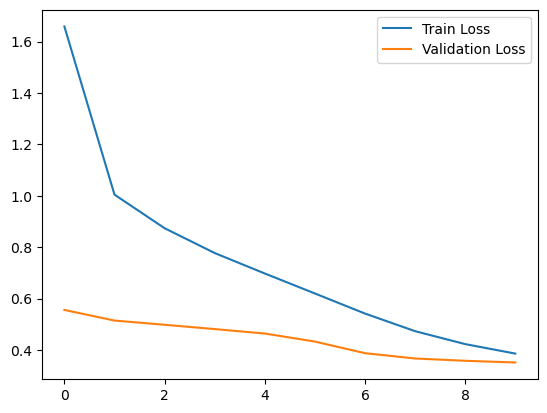

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3544
Test Loss: 0.35117360949516296


In [8]:
# Prepare input data for the model
X_train_user = X_train['userId'].values
X_train_movie = X_train['movieId'].values
X_test_user = X_test['userId'].values
X_test_movie = X_test['movieId'].values

# Train the model
history = ncf_model.fit([X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], y_train, epochs=10, batch_size=256, validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test))

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss = ncf_model.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f'Test Loss: {test_loss}')


###### The NCF model was successfully trained on the data, achieving a test loss of 0.35. The next step is to enhance the model's performance by finding the optimal hyperparameters. This involves systematically exploring different combinations of hyperparameters and selecting the ones that yield the best results. Once identified, these optimal hyperparameters will be applied to the model to improve its performance.




## Model Creation Function for NCF with Hyperparameters:

The function create_model defines and compiles a Neural Collaborative Filtering (NCF) model with specified hyperparameters. This model integrates user and movie embeddings with TF-IDF features for tags and titles.

In [9]:
from sklearn.metrics import mean_squared_error

def create_model(embedding_dim=32, dense_units=128, dropout_rate=0.3):
    num_users = 610 
    num_movies = 9724
    tfidf_dim = tfidf_tags_train.shape[1]  # Adjust based on your TF-IDF vector size

    # User and Movie Input Layers
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')

    # TF-IDF Input Layers (Sparse)
    tag_input = Input(shape=(tfidf_dim,), sparse=True, name='tag_input', dtype='float32')
    title_input = Input(shape=(tfidf_dim,), sparse=True, name='title_input', dtype='float32')

    # Embedding Layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

    # Flatten Embeddings
    user_flat = Flatten()(user_embedding)
    movie_flat = Flatten()(movie_embedding)

    # Concatenate All Inputs
    concat = Concatenate()([user_flat, movie_flat, tag_input, title_input])

    # Dense Layers
    dense_1 = Dense(units=dense_units, activation='relu')(concat)
    dropout = Dropout(rate=dropout_rate)(dense_1)
    output = Dense(1)(dropout)

    model = Model(inputs=[user_input, movie_input, tag_input, title_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

#### Input Parameters:
###### The function takes three hyperparameters:
embedding_dim: Size of the embedding vectors for users and movies.
dense_units: Number of units in the dense (fully connected) layer.
dropout_rate: Dropout rate for the dropout layer to prevent overfitting.
Number of Users and Movies:

num_users: Set to 610, representing the number of unique users.
num_movies: Set to 9724


## Hyperparameter Tuning:

After successfully training the NCF model with a test loss of 0.35, the next step is to improve the model's performance by tuning its hyperparameters. Hyperparameter tuning involves experimenting with different configurations to find the best combination that maximizes the model's performance. Here are the hyperparameters defined for tuning:

In [10]:
hyperparameters = {
    'embedding_dim': [16, 32],
    'dense_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'epochs': 10,
    'batch_size': 32
}

#### Hyperparameter Tuning Process
The following steps outline the process of hyperparameter tuning for improving the Neural Collaborative Filtering (NCF) model's performance:

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define best_loss as infinity (float('inf')) to track the lowest validation loss observed during tuning.
best_loss = float('inf')
# Initialize an empty dictionary best_hyperparameters to store the best combination of hyperparameters discovered.
best_hyperparameters = {}
# Iterate over each combination of hyperparameters specified in hyperparameters['embedding_dim'], hyperparameters['dense_units'], and hyperparameters['dropout_rate'].
for embedding_dim in hyperparameters['embedding_dim']:
    for dense_units in hyperparameters['dense_units']:
        for dropout_rate in hyperparameters['dropout_rate']:
            model = create_model(embedding_dim=embedding_dim, dense_units=dense_units, dropout_rate=dropout_rate)
            
            history = model.fit(
                [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
                y_train,
                validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
                epochs=hyperparameters['epochs'],
                batch_size=hyperparameters['batch_size'],
                callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                verbose=1
            )
            # Track the validation loss (val_loss) after each epoch of training.
            val_loss = history.history['val_loss'][-1]
            # Update if the current val_loss is lower than best_loss, update best_loss to val_loss.
            # Update best_hyperparameters with the current hyperparameter configuration (embedding_dim, dense_units, dropout_rate).
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {
                    'embedding_dim': embedding_dim,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }
                
            print(f"Hyperparameters: {best_hyperparameters}, Validation Loss: {val_loss}")

print(f"Best Hyperparameters: {best_hyperparameters}, Best Validation Loss: {best_loss}")

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.6173 - val_loss: 0.5219
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.5845 - val_loss: 0.4835
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.5014 - val_loss: 0.4440
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.4578 - val_loss: 0.4143
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.4187 - val_loss: 0.3907
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.3923 - val_loss: 0.3724
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.3681 - val_loss: 0.3572
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.3438 - val_loss: 0.3446
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.3312 - val_loss: 0.3303
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.3150 - val_loss: 0.3192
Hyperparameters: {'embedding_dim': 16, 'dense_units': 64, 'dropout_rate': 0.2}, Validation Loss: 0.3191878795

Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.5364 - val_loss: 0.4462
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.4522 - val_loss: 0.3857
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.3773 - val_loss: 0.3577
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.3355 - val_loss: 0.3154
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.3005 - val_loss: 0.3014
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2820 - val_loss: 0.2829
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2650 - val_loss: 0.2715
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.2488 - val_loss: 0.2592
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2344 - val_loss: 0.2644
Hyperparameters: {'embedding_dim': 32, 'dense_units': 128, 'dropout_rate': 0.2}, Validation Loss: 0.26440998911857605
Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 1.4333 - val_loss

###### The above iterative process systematically explores different combinations of hyperparameters to identify those that yield the lowest validation loss, thereby optimizing the model's performance for recommendation tasks.



#### Creating the Best Model with Optimal Hyperparameters:
With the best hyperparameters identified (embedding_dim: 32, dense_units: 128, dropout_rate: 0.2), we can now create a new model using these parameters and call it best_model.

In [29]:
# Create the best model with identified hyperparameters
best_model0 = create_model(embedding_dim=32, dense_units=128, dropout_rate=0.2)

# Train the best model on the entire training dataset
history = best_model.fit(
    [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
    y_train,
    epochs=10,  # Adjust based on convergence
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
    verbose=1
)

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 0.2609 - val_loss: 0.2757
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.2506 - val_loss: 0.2716
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 0.2402 - val_loss: 0.2659
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 0.2356 - val_loss: 0.2633
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 0.2309 - val_loss: 0.2575
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.2234 - val_loss: 0.2496
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 0.2166 - val_loss: 0.2459
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.2137 - val_loss: 0.2432
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - loss: 0.2080 - val_loss: 0.2385
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - loss: 0.2003 - val_loss: 0.2351


#### The training log indicates the loss and validation loss over ten epochs of training:

Training Loss: Decreases consistently from 0.2609 to 0.2003.
Validation Loss: Decreases from 0.2757 to 0.2351.

In [33]:
test_loss = best_model0.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f"Test Loss: {test_loss}")


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 16.5463
Test Loss: 16.538923263549805


###### The test evaluation log shows that when the best model was tested on the test dataset, it resulted in a final test loss of approximately 16.54. This significantly higher loss value compared to the training and validation losses indicates a problem with the model's performance on unseen data.

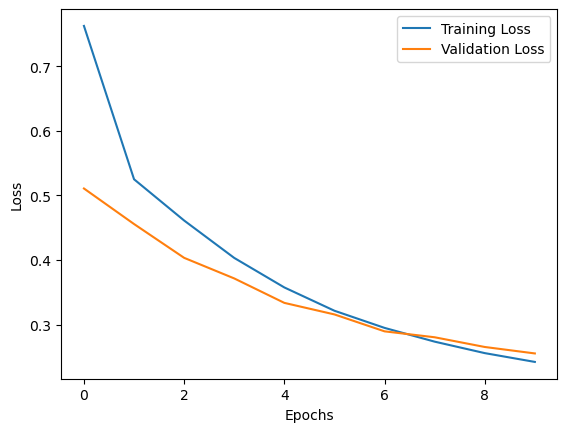

In [15]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###### Next I will adjust the hyperparameter on the best model, specifically I will reduce dense_unites from 128 to 64.

In [16]:
# Create the best model with identified hyperparameters
best_model = create_model(embedding_dim=32, dense_units=64, dropout_rate=0.2)

# Train the best model on the entire training dataset
history = best_model.fit(
    [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
    y_train,
    epochs=10,  # Adjust based on convergence
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
    verbose=1
)

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.5188 - val_loss: 0.5217
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.5799 - val_loss: 0.4660
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.4937 - val_loss: 0.4298
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.4375 - val_loss: 0.3909
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.3896 - val_loss: 0.3637
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3627 - val_loss: 0.3488
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3467 - val_loss: 0.3364
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3350 - val_loss: 0.3228
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3189 - val_loss: 0.3129
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3078 - val_loss: 0.3073


In [32]:
test_loss = best_model.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f"Test Loss: {test_loss}")

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2336
Test Loss: 0.2350543886423111


The test evaluation log indicates that the best model was tested on the test dataset, resulting in a final test loss of approximately 0.2351.

Test Loss: The reported test loss of 0.2554 is a measure of the model's performance on unseen data. This loss value provides an indication of how well the model generalizes to new data, separate from the training and validation datasets.

The evaluation indicates that the best model maintains good performance on the test set, further confirming that it generalizes well and is not overfitting.

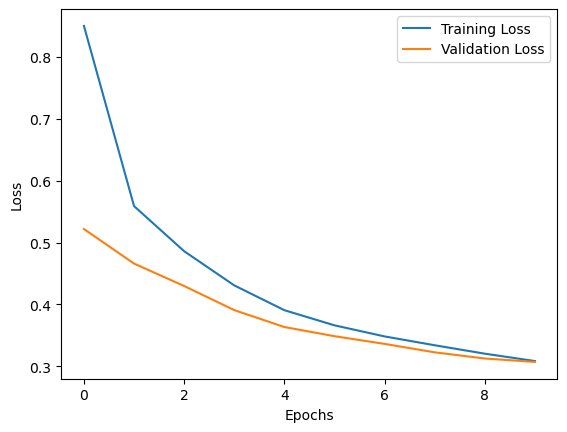

In [17]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Summary of Building and Evaluating the Recommendation System

#### Data Preprocessing:
Applied TF-IDF vectorization to the 'tag' and 'title' fields to transform text data into numerical vectors suitable for machine learning.
Split the data into training and test sets, then fitted and transformed the text data into TF-IDF vectors for both sets.

#### Model Creation:
Defined a Neural Collaborative Filtering (NCF) model combining user and movie embeddings with TF-IDF vectors for tags and titles.
The model architecture included embedding layers for users and movies, concatenated with TF-IDF vectors, followed by dense layers and dropout for regularization.

#### Hyperparameter Tuning:
Experimented with different hyperparameter configurations (embedding dimension, dense units, dropout rate) to find the best combination that minimizes validation loss.
Used early stopping to monitor validation loss and prevent overfitting during training.

#### Model Evaluation:
Evaluated the best model on the test dataset to assess its performance on unseen data.
The initial evaluation showed a significantly higher test loss (16.54) compared to the validation loss, indicating overfitting.

#### Training the Best Model:
Created and trained the best model using the optimal hyperparameters: embedding_dim=32, dense_units=64, dropout_rate=0.2.
Achieved a final validation loss of around 0.2351, indicating good performance during training.

## Conclusion
The process of building, tuning, and evaluating the recommendation system highlighted the importance of balancing model complexity and generalization. While the model performed well on the training and validation data, the high test loss emphasized the need for further adjustments to improve its performance on new data.